## import

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import networkx as nx

from causalnex.structure.pytorch import from_pandas
from causalnex.structure import StructureModel
from causalnex.network import BayesianNetwork
from causalnex.evaluation import classification_report, roc_auc
from causalnex.inference import InferenceEngine


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

import optuna

import warnings
warnings.simplefilter('ignore')
import os

## 関数読み込み

### ベイズ最適化関数, スコアリング関数, 構造学習関数, 連番生成関数, ネットワーク可視化関数

In [2]:
# cuda割り当て
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# ベイズ最適化関数
def objective_variable_degree(data):
    # 目的関数
    def objective(trial):
        # Optunaでチューニングするハイパーパラメータ
        max_iter = trial.suggest_int('max_iter', 100, 1000)
        threshold = trial.suggest_float('threshold', 0.0, 1.0)
        lasso_beta = trial.suggest_float('lasso_beta', 1e-4, 1e-1, log=True)  # ログスケールでlassoの値を探索
        ridge_beta = trial.suggest_float('ridge_beta', 1e-4, 1e-1, log=True)  # リッジ正則化の係数を探索
        use_bias = trial.suggest_categorical('use_bias', [True, False])

        # StructureModelのインスタンスを作成
        sm = StructureModel()

        # NOTEARSアルゴリズムを用いて構造学習を実施
        # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
        sm, loss_value = from_pandas(data, 
                                    max_iter=max_iter,
                                    w_threshold=threshold,
                                    lasso_beta=lasso_beta,
                                    ridge_beta=ridge_beta,
                                    use_bias=use_bias,
                                    )

        # 学習された構造のスコアを計算（スコアリング方法はプロジェクトにより異なる）
        score = calculate_score(sm)

        return score
    return objective

# スコアリング関数（例：エッジ数でスコアリング）
def calculate_score(sm):
    return -len(sm.edges)  # エッジの数が少ないほどスコアが高くなるように設定

# 構造学習用関数
def Learning(num, study, data):
    # 最適な閾値を取得
    best_max_iter = study.best_params['max_iter']
    best_threshold = study.best_params['threshold']
    my_driven_hidden_layer_units = [num] # 中間層
    best_lasso_beta = study.best_params['lasso_beta']
    best_ridge_beta = study.best_params['ridge_beta']
    best_use_bias = study.best_params['use_bias']

    # 最適な閾値で構造学習を実施
    best_sm, loss_value = from_pandas(data,
                                    max_iter=best_max_iter,
                                    w_threshold=best_threshold,
                                    hidden_layer_units=my_driven_hidden_layer_units,
                                    lasso_beta=best_lasso_beta,
                                    ridge_beta=best_ridge_beta,
                                    use_bias=best_use_bias,
                                    )

    best_sm.threshold_till_dag()

    return loss_value, best_sm

# 連番生成関数
def create_filename(base_name, directory='.', extension='.png'):
    counter = 1
    while True:
        file_name = f"{base_name}_{counter}{extension}"
        full_path = os.path.join(directory, file_name)
        if not os.path.exists(full_path):
            return full_path
        counter += 1

# ネットワーク可視化関数
def drow_network(learning_condition, param_condition, sm_l, edge_width, save_path):
    fig, ax = plt.subplots(figsize=(16,16))
    # ネットワークのタイトル
    plt.suptitle('代謝反応ネットワーク', y=1.03, fontsize=20)
    # ネットワークの条件を表示
    plt.figtext(0.7, 1.0, f'[学習条件]\n{learning_condition}\n\n[パラメータ条件]\n{param_condition}', ha='left', va='top', fontsize=16)
    nx.draw_circular(sm_l,
                    with_labels=True,
                    font_size=20,
                    node_size=3000,
                    arrowsize=20,
                    alpha=0.5,
                    width=edge_width,
                    ax=ax)

    plt.savefig(save_path, format="png", dpi=300, bbox_inches='tight')

## データ読み込みから前処理

### データ読み込み

In [3]:
path = '../data/231021-1110_AI用qPCRデータ.xlsx'

df = pd.read_excel(path, index_col=0, header=1)
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)

(211, 33)


### 正規化

In [4]:
# Normalization
scaler = StandardScaler()
normalized_data_array = scaler.fit_transform(df)
# conversion array to Dataframe
normalized_df = pd.DataFrame(normalized_data_array, columns=df.columns)

## パラメータ探索と構造学習

### パラメータ

**lasso_beta(Lasso推定量)**: 過学習を防いだり，モデルを単純にするために不要なパラメータを削っていると大きくなる．
- Lassoは不要な係数を0にすることができるので変数選択に有効 -> 変数選択をするので多重共線性にも有効?
- 過剰な係数を縮小させるので過学習の防止
- 高次元データ(遺伝子データなど)に効果的な特徴量選択とモデルの単純化を行うことができる．

**注意点**
- ラムダの選択(パラメータチューニング)を間違えるとモデルの性能に大きく影響が出る．

**ridge_beta(Ridge推定量)**: 大きな特徴量にペナルティーを与えて重みを調整し，過学習を回避している場合に大きくなる．
- 多重共線性(変数間に強い相関)がある場合，安定したパラメータ推定を行うので有効
    - 損失関数に係数の二乗の和に基づくL2正則化項を加えるので，係数の絶対値の合計が大きくなりすぎることを防ぐ．
    - 正則化によりパラメータが過大になることを抑え，特徴間の相関が強い場合でもパラメータが不安定になるのを防ぐ．
    - 上記2点の効能により，モデルが安定しやすくなる．
- 次元の呪い(特徴量の過多)がある場合に，モデルの一般化能力を向上させるのに向いている
- 多重共線性の問題を緩和し，過学習を回避することでモデルの未知のデータに対する一般化能力を高め，より堅牢で信頼性の高い予測モデルとなる．

**L1とL2のユースケース**
- 特徴量が少ない or 解釈しやすい(特徴量が少ない)モデルが欲しい場合はラッソ回帰
- 特徴量の多いデータの場合はリッジ回帰
- 計算コストは上がるが，どっちも適度に使用することで予測性能の高いモデルを作ることができる．

### 用語

**次元の呪い**: データの次元（特徴の数）が増加するにつれ，統計・機械学習モデルの性能に悪影響を及ぼす一連の問題を指す．
- 単純に計算コストの増加
- サンプル数問題: 高次元データを扱うためのサンプル数が足りない場合，過学習を引き起こす
- データの希薄化
- モデルの解釈性の低下

**多重共線性**: 多重共線性は，予測モデルにおいて二つ以上の予測変数（特徴）が高い相関を持つ状況を指す．
- 共線性が存在すると，線形回帰モデルの係数の推定が不安定になり，過剰に大きな値をとることがある．これは，モデルが訓練データのランダムなノイズに過剰に適合し，未知のデータに対する予測性能が低下する原因となる．

### パラメータ探索

In [6]:
# スコア(エッジの数)を最大化するように設定
study = optuna.create_study(direction='maximize')
# 100回の試行で最適化
study.optimize(objective_variable_degree(normalized_df), n_trials=100)
# ログ非表示
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# 最適なハイパーパラメータを出力
print(study.best_params)

[I 2023-11-13 00:32:28,017] A new study created in memory with name: no-name-004f9033-06af-48ad-adb1-d28e772c4e9a
[I 2023-11-13 00:32:41,429] Trial 0 finished with value: -180.0 and parameters: {'max_iter': 437, 'threshold': 0.2555658899124994, 'lasso_beta': 0.004507832686410682, 'ridge_beta': 0.05172240907018162, 'use_bias': False}. Best is trial 0 with value: -180.0.
[I 2023-11-13 00:32:55,521] Trial 1 finished with value: -36.0 and parameters: {'max_iter': 811, 'threshold': 0.7310269390773039, 'lasso_beta': 0.0008801183895870793, 'ridge_beta': 0.010530791420936653, 'use_bias': False}. Best is trial 1 with value: -36.0.
[I 2023-11-13 00:33:11,535] Trial 2 finished with value: -364.0 and parameters: {'max_iter': 130, 'threshold': 0.07686967119761046, 'lasso_beta': 0.00016139210128815698, 'ridge_beta': 0.0003697687211227541, 'use_bias': True}. Best is trial 1 with value: -36.0.
[I 2023-11-13 00:33:26,323] Trial 3 finished with value: -17.0 and parameters: {'max_iter': 800, 'threshold':

{'max_iter': 704, 'threshold': 0.9967697480017464, 'lasso_beta': 0.06830214894801089, 'ridge_beta': 0.028958845771483086, 'use_bias': True}


### 構造学習

In [9]:
# 中間層の数
num_of_mid = 2
# 構造学習実行
loss_value, best_sm = Learning(num_of_mid, study, normalized_df)

print('-'*50)
# 損失関数の出力
print("損失関数:", loss_value)
# 学習モデルに含まれるノード一覧
print("ノード:", best_sm.nodes)
print('-'*50)

# エッジが伸びていないノードを排除, 関係性の強いエッジを太くする
edge_width = [d["weight"]*1 for (u, v, d) in best_sm.edges(data=True)]
# 上記の処置を施したものを新たなグラフとして保存
sm_l = best_sm.get_largest_subgraph()
print("構造モデル:", sm_l)
print('-'*50)

--------------------------------------------------
損失関数: 0.8723671312909573
ノード: ['glk', 'agp', 'yihX', 'pgm', 'ptsG', 'malx', 'crr', 'galM', 'yihR', 'yeaD', 'pgi', 'ascF', 'chbF', 'ascB', 'bglA', 'bglB', 'yggF', 'glpX', 'fbp', 'pfkB', 'pfkA', 'fbaB', 'fbaA', 'tpiA', 'gapA', 'pgk', 'gpmA', 'ytjc', 'gpmM', 'eno', 'pykF', 'pykA', 'ppsA']
--------------------------------------------------
構造モデル: StructureModel with 4 nodes and 3 edges
--------------------------------------------------


## 可視化

Saved as: ././output/networks/best_network_3.png


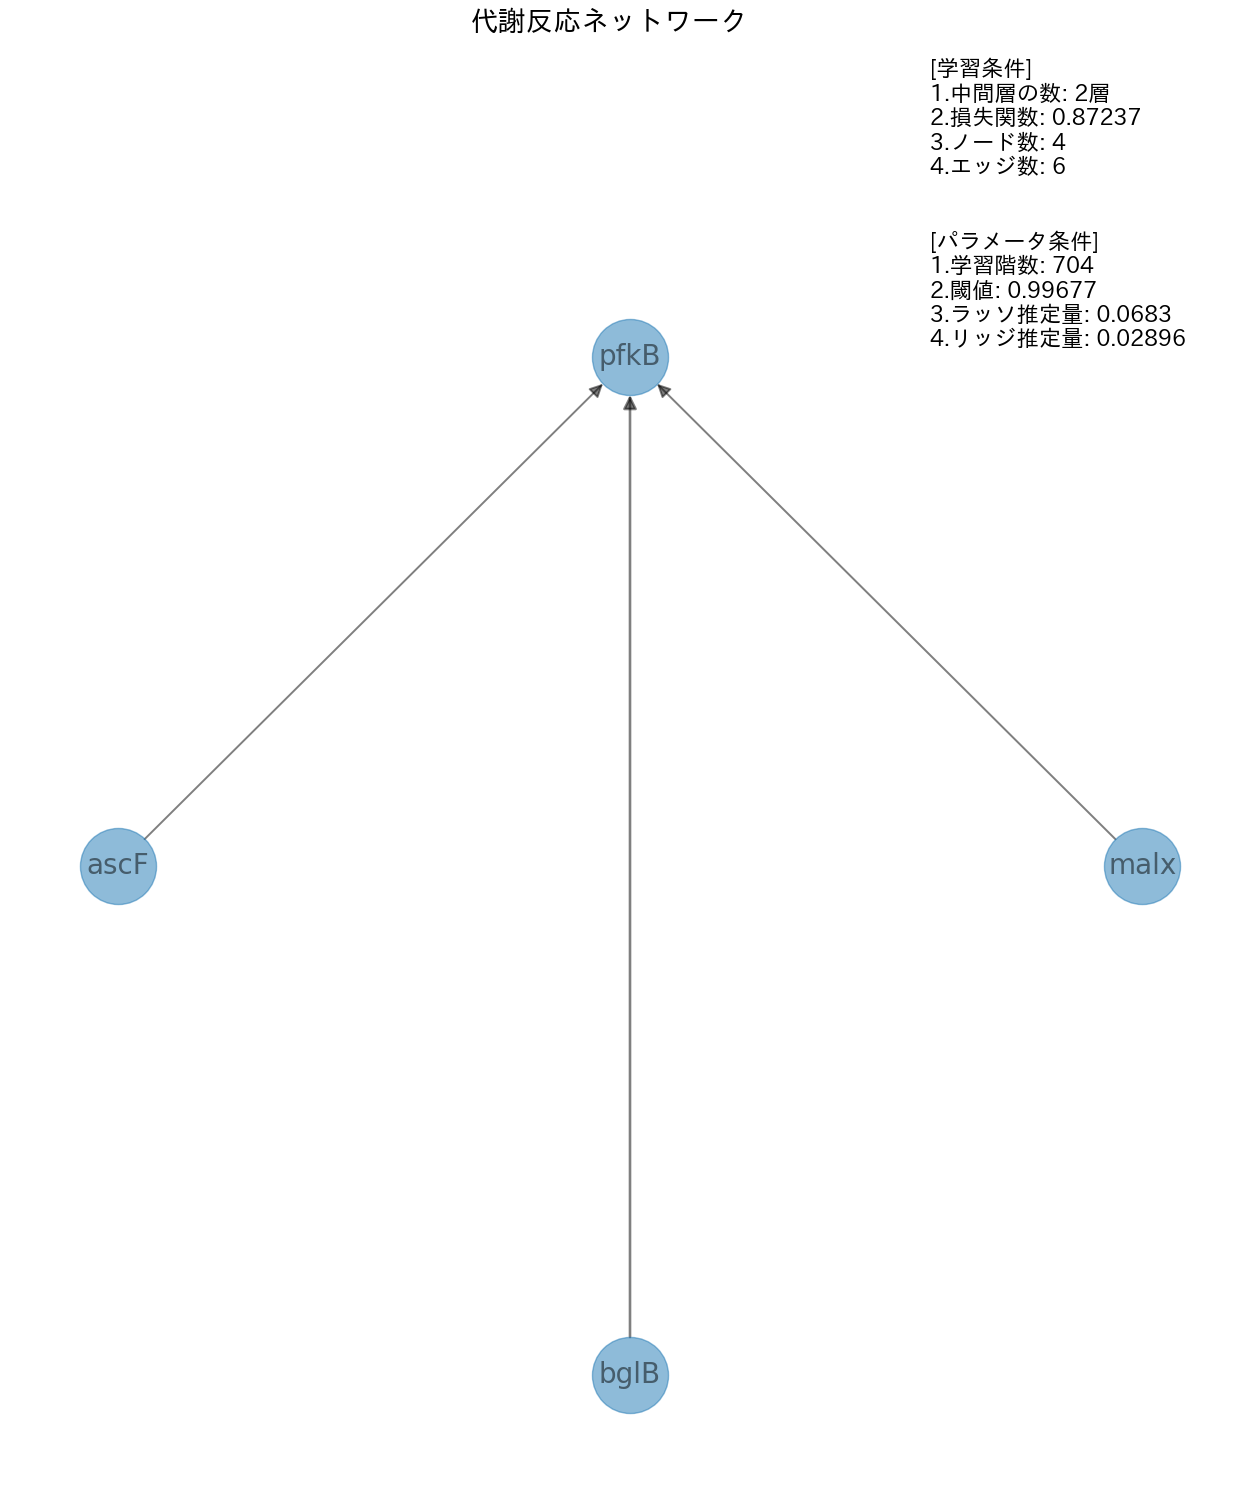

In [10]:
# 学習条件
learning_condition = f'1.中間層の数: {num_of_mid}層\n2.損失関数: {round(loss_value, 5)}\n3.ノード数: {len(sm_l.nodes)}\n4.エッジ数: {sum(len(t) for t in sm_l.edges)}\n'
param_condition = f'1.学習階数: {study.best_params["max_iter"]}\n2.閾値: {round(study.best_params["threshold"], 5)}\n3.ラッソ推定量: {round(study.best_params["lasso_beta"], 5)}\n4.リッジ推定量: {round(study.best_params["ridge_beta"], 5)}\n'
# 保存先指定
file_path = create_filename('./output/networks/best_network')
# 可視化関数実行
drow_network(learning_condition, param_condition, sm_l, edge_width, file_path)
print(f"Saved as: {file_path}")

## ベイジアンネットワーク

### 離散化処理

In [11]:
# Discretize the features
# Excluding the first column which seems to be an index or identifier
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
discretised_data = discretizer.fit_transform(normalized_df.iloc[:, :])

# Creating a new DataFrame for the discretized data
discretised_data = pd.DataFrame(discretised_data, columns=normalized_df.columns)

# Display the first few rows of the discretized data
discretised_data.head()

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# 構造モデルのノードの確認
nodes = list(sm_l.nodes)
print('nodes:', nodes)

nodes: ['malx', 'pfkB', 'ascF', 'bglB']


In [13]:
bn = BayesianNetwork(sm_l)
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train)

for i in range(len(nodes)):
    print(nodes[i])
    display(bn.cpds[nodes[i]])

malx


,
malx,
0.0,0.984127
1.0,0.015873


pfkB


ascF  0.0                 1.0               
bglB  0.0       1.0       0.0       1.0     
malx  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0
pfkB                                        
0.0   1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.0
1.0   0.0  0.0  0.5  0.5  0.5  0.5  0.5  1.0

ascF


,
ascF,
0.0,0.989418
1.0,0.010582


bglB


,
bglB,
0.0,0.989418
1.0,0.010582


### 評価

In [ ]:
# predictions = bn.predict(discretised_data, "pgi")
# print(discretised_data.loc[1, "pgi"])

In [ ]:
# display(classification_report(bn, test, "pgi"))

### 各変数のAUC

In [14]:
for n in bn.nodes:
    roc, auc = roc_auc(bn, test, n)
    print(n, auc)

malx 0.9545454545454546
pfkB 1.0
ascF 1.0
bglB 1.0


### 条件付き確率の可視化

Saved as: ././output/simple_cpds/cpd_1.png


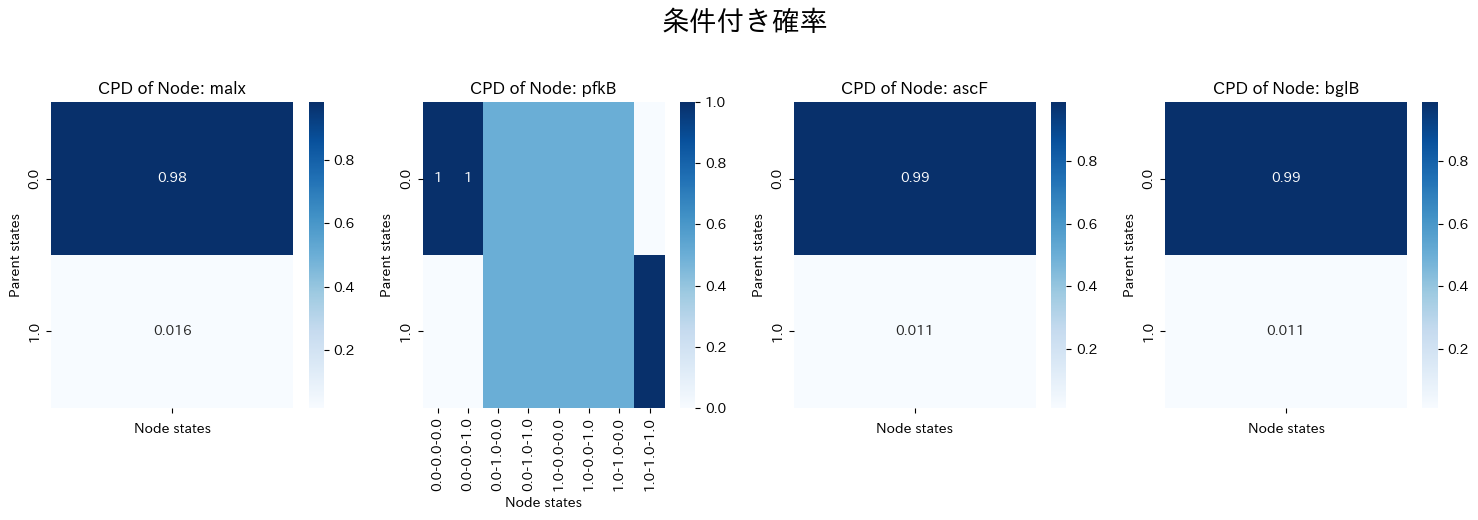

In [36]:
# ノードの数に基づいてサブプロットの行と列の数を決定
num_nodes = len(nodes)

cols = 4  # 1行に表示するヒートマップの数
rows = num_nodes // cols + (num_nodes % cols > 0)

# サブプロットのグリッドを作成
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  # 1D配列に変換
# ネットワークのタイトル
plt.suptitle('条件付き確率', y=1.03, fontsize=20)

for i, node in enumerate(nodes):
    cpd = bn.cpds[node]
    cpd_df = pd.DataFrame(cpd)

    # 対応するサブプロットにヒートマップを描画
    sns.heatmap(cpd_df, annot=True, cmap='Blues', ax=axes[i])
    axes[i].set_title(f'CPD of Node: {node}')
    axes[i].set_ylabel('Parent states' if cpd_df.shape[0] > 1 else 'State')
    axes[i].set_xlabel('Node states')

# 空のサブプロットを非表示にする
for i in range(num_nodes, rows * cols):
    axes[i // cols, i % cols].axis('off')

plt.tight_layout()
# 保存先指定
file_path = create_filename('./output/simple_cpds/cpd')
plt.savefig(file_path, format="png", dpi=300, bbox_inches='tight')

print(f"Saved as: {file_path}")

### 介入によるシミュレーション

In [30]:
# InferenceEngineを初期化
engine = InferenceEngine(bn)

# 介入を行うノードとその状態を選択
intervention_node = nodes[2]
intervention_state_0 = 0.0  # 離散化された状態の例
intervention_state_1 = 1.0  # 離散化された状態の例
num_0 = 0.0  # 発生しない確率
num_1 = 1.0  # 発生する確率

intervention_condition = f'intervention node: {intervention_node} \n 発生しない確率: {num_0}, 発生する確率: {num_1}'

print(f"介入前の{intervention_node}: ", engine.query())

# 介入を実行
engine.do_intervention(intervention_node, {intervention_state_0: num_0,
                                           intervention_state_1: num_1})

print(f"介入後の{intervention_node}: ", engine.query())

# 介入後の確率分布を確認
marginals_after_intervention = engine.query()


介入前のascF:  {'malx': {0.0: 0.9841269841269842, 1.0: 0.01587301587301587}, 'pfkB': {0.0: 0.9894730901701592, 1.0: 0.01052690982984088}, 'ascF': {0.0: 0.9894179894179894, 1.0: 0.010582010582010583}, 'bglB': {0.0: 0.9894179894179894, 1.0: 0.010582010582010581}}
介入後のascF:  {'malx': {0.0: 0.984126984126984, 1.0: 0.015873015873015872}, 'pfkB': {0.0: 0.4999160157890316, 1.0: 0.5000839842109683}, 'ascF': {0.0: 0.0, 1.0: 0.9999999999999998}, 'bglB': {0.0: 0.9894179894179893, 1.0: 0.010582010582010581}}


ascF介入後のmalxの周辺分布: {0.0: 0.984126984126984, 1.0: 0.015873015873015872}
ascF介入後のpfkBの周辺分布: {0.0: 0.4999160157890316, 1.0: 0.5000839842109683}
ascF介入後のascFの周辺分布: {0.0: 0.0, 1.0: 0.9999999999999998}
ascF介入後のbglBの周辺分布: {0.0: 0.9894179894179893, 1.0: 0.010582010582010581}
Saved as: ././output/intervention_cpds/ascF_CPD_heatmap.png_1.png


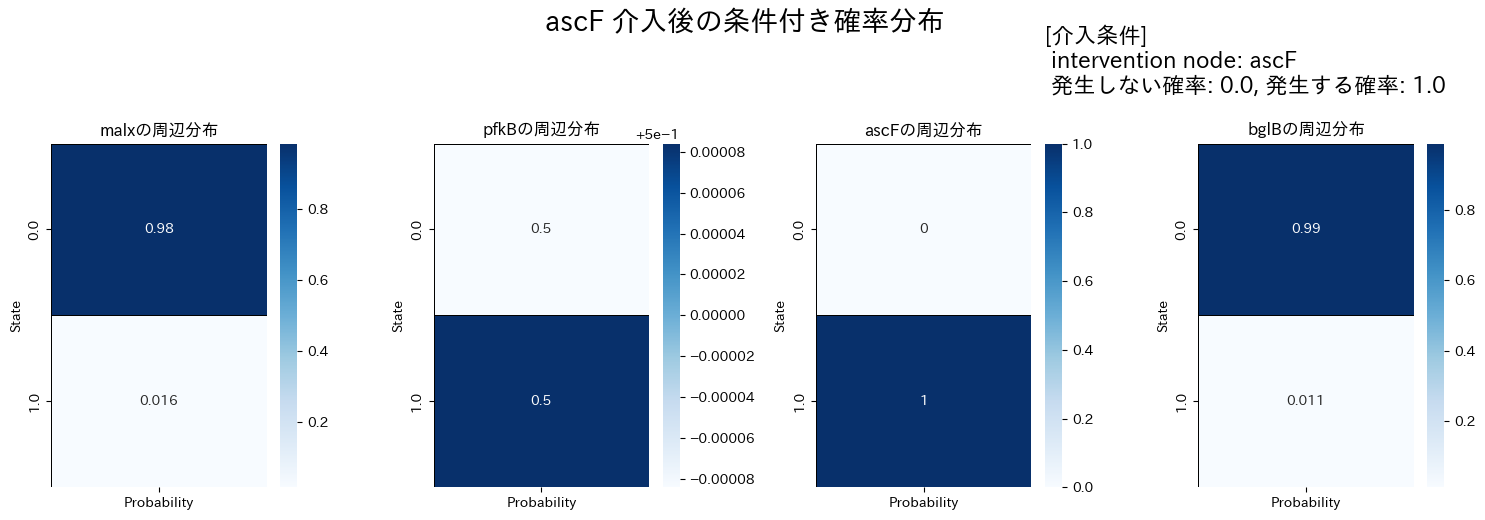

In [38]:
# 結果を表示
for node in nodes:
    print(f"{intervention_node}介入後の{node}の周辺分布: {marginals_after_intervention[node]}")

# ノードの数に基づいてサブプロットの行と列の数を決定
num_nodes = len(nodes)
cols = 4  # 1行に表示するヒートマップの数
rows = num_nodes // cols + (num_nodes % cols > 0)

# サブプロットを作成
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))
plt.suptitle(f'{intervention_node} 介入後の条件付き確率分布', y=1.03, fontsize=20)
# 介入の条件を表示
plt.figtext(0.7, 1.0, f'[介入条件] \n {intervention_condition}', ha='left', va='top', fontsize=16)

for i, node in enumerate(nodes):
    cpd_dict = engine.query()[node]
    cpd_df = pd.DataFrame(list(cpd_dict.items()), columns=['State', 'Probability'])

    # 現在のサブプロットを取得
    ax = axs[i // cols, i % cols] if rows > 1 else axs[i]

    # ヒートマップを描画
    sns.heatmap(cpd_df.set_index('State'), annot=True, cmap='Blues', linecolor='black', linewidths=0.5, ax=ax)
    ax.set_title(f'{node}の周辺分布')
    ax.set_xlabel('')
    ax.set_ylabel('State')

# 空のサブプロットを非表示にする
for i in range(num_nodes, rows * cols):
    axs[i // cols, i % cols].axis('off')

# レイアウトを調整
plt.tight_layout(rect=[0, 0, 1, 0.92])  # rectパラメータで上部の空間を確保

# 保存先指定
file_path = create_filename(f"./output/intervention_cpds/{intervention_node}_CPD_heatmap.png")
plt.savefig(file_path, format="png", dpi=300, bbox_inches='tight')

print(f"Saved as: {file_path}")